In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from feature_engine.encoding import (
    CountFrequencyEncoder
)

In [2]:
url = 'dataset/train.csv'
train = pd.read_csv(url)
train.head()

,ID,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income
0,478,1992,Swasta,37210,Sarjana,Sarjana,Menikah,Eksekutif Manager,Suami,1,Male,0,0,45,United-States,2,>50K
1,479,1981,Swasta,101950,Magister,Magister,Belum-menikah,Eksekutif Manager,Tidak dalam Keluarga,1,Female,0,0,45,United-States,0,<=50K
2,480,2004,NaN,122244,SMA Grad,SMA Grad,Belum-menikah,NaN,Tidak dalam Keluarga,1,Female,0,0,28,United-States,0,<=50K
3,481,1984,Pemerintah daerah,24763,Diploma,Kuliah,Cerai,Transportasi dan Pengangkutan,Belum Menikah,1,Male,6849,0,40,United-States,0,<=50K
4,482,2000,Swasta,113936,Sarjana,Sarjana,Belum-menikah,Spesialis Profesional,Punya Anak,1,Male,0,0,40,United-States,0,<=50K


## Data Preprocessing

In [3]:
# Dropping unnecessary column
train.drop('ID', axis=1, inplace=True)
train.head(2)

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income
0,1992,Swasta,37210,Sarjana,Sarjana,Menikah,Eksekutif Manager,Suami,1,Male,0,0,45,United-States,2,>50K
1,1981,Swasta,101950,Magister,Magister,Belum-menikah,Eksekutif Manager,Tidak dalam Keluarga,1,Female,0,0,45,United-States,0,<=50K


In [4]:
# function to check missing & duplicated values
def check_data(df):
    print('-' *50)
    
    missing_data = df.isnull().sum().sum()
    
    print(f'There are {missing_data} missing values in the dataset.')
    print(f'There are {df.duplicated().sum().sum()} duplicated values in the dataset.')
    print('-' *50)
    
    if missing_data > 0:
        print('Missing values:')
        print(df.isnull().sum().sort_values(ascending=False))
        print('-' *50)


In [5]:
check_data(train)

--------------------------------------------------
There are 2956 missing values in the dataset.
There are 35 duplicated values in the dataset.
--------------------------------------------------
Missing values:
Pekerjaan             1481
Kelas Pekerjaan       1475
Tahun Kelahiran          0
fnlwgt                   0
Pendidikan               0
Jenjang Pendidikan       0
Status                   0
Hubungan                 0
Etnis                    0
sex                      0
pendapatan               0
pengeluaran              0
hours per week           0
Asal Negara              0
jumlah_anak              0
income                   0
dtype: int64
--------------------------------------------------


## Feature Engineering

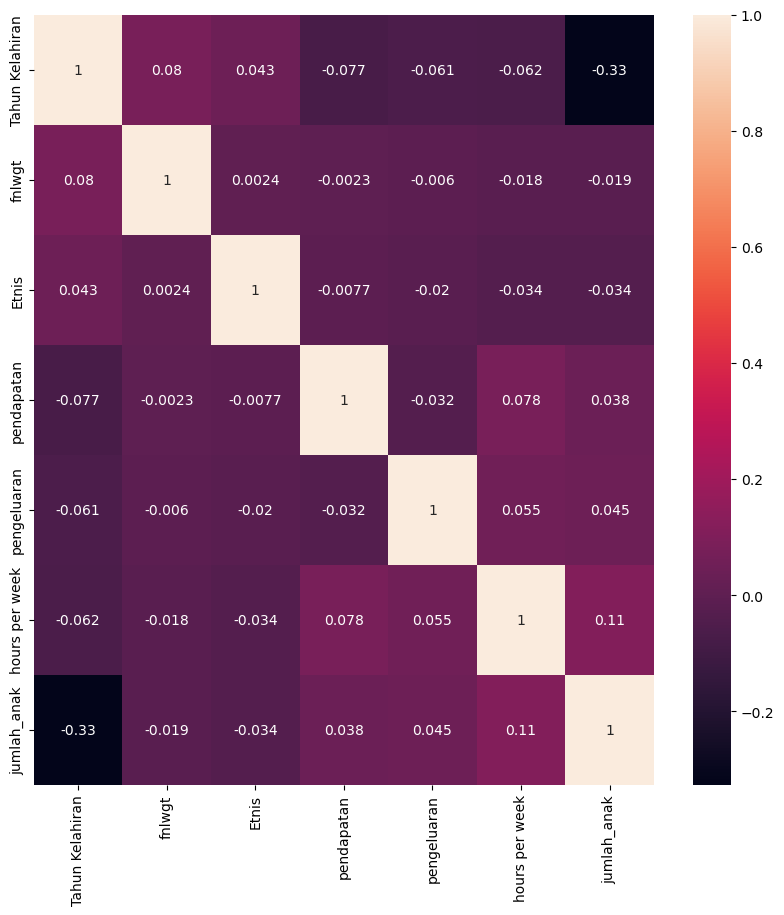

In [6]:
num_cols = [var for var in train.columns if train[var].dtypes != 'O']
corr_mat = train[num_cols].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_mat, annot=True)
plt.show()

Not using linear based model

### Fixing data format

In [7]:
cat_cols = [var for var in train.columns if train[var].dtypes == 'O']

for col in train[cat_cols]:
    print(f'{col}: {train[col].unique()}')
    print('-' *50)

Kelas Pekerjaan: ['Swasta' nan 'Pemerintah daerah' 'Pengusaha berbadan hukum'
 'Pemerintah pusat' 'Pengusaha perorangan' 'Pemerintah negara'
 'Tanpa bayaran' 'Tidak bekerja']
--------------------------------------------------
Pendidikan: ['Sarjana' 'Magister' 'SMA Grad' 'Diploma' 'Asosiasi akademik' 'kelas 10'
 'kelas 9' 'kelas 7-8' 'Asosiasi vokasional' 'kelas 11' 'kelas 5-6'
 'Proffesor' 'kelas 12' 'Doktor' 'kelas 1-4' 'TK']
--------------------------------------------------
Jenjang Pendidikan: ['Sarjana' 'Magister' 'SMA Grad' 'Kuliah' 'vokasi Grad_1' 'SMA_1' 'SMP_2'
 'SMP_1' 'vokasi Grad_2' 'SMA_2' 'SD_2' 'Doktor' 'SMA_3' 'Proffesor'
 'SD_1' 'TK']
--------------------------------------------------
Status: ['Menikah' 'Belum-menikah' 'Cerai' 'Duda/Janda' 'Rencana Cerai'
 'Menikahi tentara' 'LDM']
--------------------------------------------------
Pekerjaan: ['Eksekutif Manager' nan 'Transportasi dan Pengangkutan'
 'Spesialis Profesional' 'Dukungan Teknis' 'Pekerjaan Kerajinan' 'Sales'

Fixing `Pendidikan` column

In [8]:
train['Pendidikan'].value_counts()

Pendidikan
SMA Grad               8387
Diploma                5820
Sarjana                4261
Magister               1407
Asosiasi vokasional    1111
kelas 11                933
Asosiasi akademik       876
kelas 10                729
kelas 7-8               526
Proffesor               462
kelas 9                 409
kelas 12                354
Doktor                  330
kelas 5-6               282
kelas 1-4               140
TK                       42
Name: count, dtype: int64

In [9]:
# replace kelas 10, kelas 11, kelas 12 with SMA
train['Pendidikan'] = train['Pendidikan'].replace(['kelas 10', 'kelas 11', 'kelas 12'], 'SMA')

# replace kelas 7-8, kelas 9 with SMP
train['Pendidikan'] = train['Pendidikan'].replace(['kelas 7-8', 'kelas 9'], 'SMP')

# replace kelas 1-4, kelas 5-6 with SD
train['Pendidikan'] = train['Pendidikan'].replace(['kelas 1-4', 'kelas 5-6'], 'SD')

# # replace
# train['Pendidikan'] = train['Pendidikan'].replace(['Diploma', 'Asosiasi akademik', 'Asosiasi vokasional',
#                                                    'Sarjana', 'Magister', 'Doktor', 'Proffesor', 'SMA Grad'], 'Pendidikan Tinggi')

train['Pendidikan'].value_counts()

Pendidikan
SMA Grad               8387
Diploma                5820
Sarjana                4261
SMA                    2016
Magister               1407
Asosiasi vokasional    1111
SMP                     935
Asosiasi akademik       876
Proffesor               462
SD                      422
Doktor                  330
TK                       42
Name: count, dtype: int64

Fixing `Status` column

In [10]:
train['Status'].value_counts()

Status
Menikah             12012
Belum-menikah        8505
Cerai                3564
Rencana Cerai         826
Duda/Janda            812
LDM                   332
Menikahi tentara       18
Name: count, dtype: int64

In [11]:
# replacing menikahi tentara with Menikah
train['Status'] = train['Status'].replace(['Menikahi tentara', 'LDM'], 'Menikah')

train['Status'].value_counts()

Status
Menikah          12362
Belum-menikah     8505
Cerai             3564
Rencana Cerai      826
Duda/Janda         812
Name: count, dtype: int64

Fixing `Hubungan` column (**PENDING)

In [12]:
train['Hubungan'].value_counts()

Hubungan
Suami                   10598
Tidak dalam Keluarga     6675
Punya Anak               4036
Belum Menikah            2736
Istri                    1233
Kerabat                   791
Name: count, dtype: int64

Fixing `Kelas Pekerjaan` column

In [13]:
train['Kelas Pekerjaan'].value_counts()

Kelas Pekerjaan
Swasta                      18114
Pengusaha perorangan         2043
Pemerintah daerah            1705
Pemerintah negara            1053
Pengusaha berbadan hukum      894
Pemerintah pusat              766
Tanpa bayaran                  13
Tidak bekerja                   6
Name: count, dtype: int64

In [14]:
# replacing with sektor pemerintah affiliated
train['Kelas Pekerjaan'] = train['Kelas Pekerjaan'].replace(['Pemerintah pusat', 'Pemerintah daerah',
                                                             'Pemerintah negara'], 'Sektor Pemerintah')

# train['Kelas Pekerjaan'] = train['Kelas Pekerjaan'].replace(['Tanpa bayaran', 'Tidak bekerja'], '')

train['Kelas Pekerjaan'].value_counts()

Kelas Pekerjaan
Swasta                      18114
Sektor Pemerintah            3524
Pengusaha perorangan         2043
Pengusaha berbadan hukum      894
Tanpa bayaran                  13
Tidak bekerja                   6
Name: count, dtype: int64

In [15]:
# no_income feature column
train['no_income'] = train['Kelas Pekerjaan'].apply(lambda x: 1 if x == 'Tanpa bayaran' or x == 'Tidak bekerja' else 0)
train['no_income'].value_counts()

no_income
0    26050
1       19
Name: count, dtype: int64

Fixing `Jenjang Pendidikan` column

In [16]:
train['Jenjang Pendidikan'].value_counts()

Jenjang Pendidikan
SMA Grad         8387
Kuliah           5820
Sarjana          4261
Magister         1407
vokasi Grad_2    1111
SMA_2             933
vokasi Grad_1     876
SMA_1             729
SMP_1             526
Doktor            462
SMP_2             409
SMA_3             354
Proffesor         330
SD_2              282
SD_1              140
TK                 42
Name: count, dtype: int64

In [17]:
# replace SMA_1, SMA_2, SMA_3 with SMA
train['Jenjang Pendidikan'] = train['Jenjang Pendidikan'].replace(['SMA_1', 'SMA_2', 'SMA_3'], 'SMA')

# replace SMP_1, SMP_2, SMP_3 with SMP
train['Jenjang Pendidikan'] = train['Jenjang Pendidikan'].replace(['SMP_1', 'SMP_2', 'SMP_3'], 'SMP')

# replace SD_1, SD_2, with SD
train['Jenjang Pendidikan'] = train['Jenjang Pendidikan'].replace(['SD_1', 'SD_2'], 'SD')

# replace vokasi Grad_1, vokasi Grad_2 with vokasi Grad
train['Jenjang Pendidikan'] = train['Jenjang Pendidikan'].replace(['vokasi Grad_1', 'vokasi Grad_2'], 'Vokasi Grad')

train['Jenjang Pendidikan'].value_counts()

Jenjang Pendidikan
SMA Grad       8387
Kuliah         5820
Sarjana        4261
SMA            2016
Vokasi Grad    1987
Magister       1407
SMP             935
Doktor          462
SD              422
Proffesor       330
TK               42
Name: count, dtype: int64

Fixing `Asal Negara` column

In [18]:
train['Asal Negara'].value_counts()

Asal Negara
United-States                 23355
Mexico                          532
?                               458
Philippines                     157
Germany                         109
Canada                           93
Puerto-Rico                      92
El-Salvador                      85
Cuba                             83
India                            82
England                          69
South                            68
China                            61
Jamaica                          60
Italy                            60
Dominican-Republic               58
Vietnam                          52
Poland                           48
Columbia                         48
Japan                            46
Taiwan                           44
Guatemala                        43
Haiti                            36
Iran                             31
Portugal                         30
France                           27
Greece                           25
Ecuador         

In [19]:
# replace ? with missing value
train['Asal Negara'] = train['Asal Negara'].replace(['?'], np.nan)

# replace "Hong" with "Hong Kong"
train['Asal Negara'] = train['Asal Negara'].replace(['Hong'], 'Hong Kong')

train['Asal Negara'].value_counts()

Asal Negara
United-States                 23355
Mexico                          532
Philippines                     157
Germany                         109
Canada                           93
Puerto-Rico                      92
El-Salvador                      85
Cuba                             83
India                            82
England                          69
South                            68
China                            61
Jamaica                          60
Italy                            60
Dominican-Republic               58
Vietnam                          52
Columbia                         48
Poland                           48
Japan                            46
Taiwan                           44
Guatemala                        43
Haiti                            36
Iran                             31
Portugal                         30
France                           27
Ecuador                          25
Greece                           25
Peru            

In [20]:
cat_cols = [var for var in train.columns if train[var].dtypes == 'O']

for col in train[cat_cols]:
    print(f'{col}: {train[col].unique()}')
    print('-' *50)

Kelas Pekerjaan: ['Swasta' nan 'Sektor Pemerintah' 'Pengusaha berbadan hukum'
 'Pengusaha perorangan' 'Tanpa bayaran' 'Tidak bekerja']
--------------------------------------------------
Pendidikan: ['Sarjana' 'Magister' 'SMA Grad' 'Diploma' 'Asosiasi akademik' 'SMA' 'SMP'
 'Asosiasi vokasional' 'SD' 'Proffesor' 'Doktor' 'TK']
--------------------------------------------------
Jenjang Pendidikan: ['Sarjana' 'Magister' 'SMA Grad' 'Kuliah' 'Vokasi Grad' 'SMA' 'SMP' 'SD'
 'Doktor' 'Proffesor' 'TK']
--------------------------------------------------
Status: ['Menikah' 'Belum-menikah' 'Cerai' 'Duda/Janda' 'Rencana Cerai']
--------------------------------------------------
Pekerjaan: ['Eksekutif Manager' nan 'Transportasi dan Pengangkutan'
 'Spesialis Profesional' 'Dukungan Teknis' 'Pekerjaan Kerajinan' 'Sales'
 'Layanan Lainnya' 'Pengelola Kebersihan' 'Inspeksi dan Operasi Mesin'
 'Pertanian dan Perikanan' 'Administratif dan Kantor'
 'Layanan Perlindungan' 'Pembantu Rumah Tangga' 'Angkatan B

### Encoding categorical columns

In [21]:
train[cat_cols]

,Kelas Pekerjaan,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,sex,Asal Negara,income
0,Swasta,Sarjana,Sarjana,Menikah,Eksekutif Manager,Suami,Male,United-States,>50K
1,Swasta,Magister,Magister,Belum-menikah,Eksekutif Manager,Tidak dalam Keluarga,Female,United-States,<=50K
2,NaN,SMA Grad,SMA Grad,Belum-menikah,NaN,Tidak dalam Keluarga,Female,United-States,<=50K
3,Sektor Pemerintah,Diploma,Kuliah,Cerai,Transportasi dan Pengangkutan,Belum Menikah,Male,United-States,<=50K
4,Swasta,Sarjana,Sarjana,Belum-menikah,Spesialis Profesional,Punya Anak,Male,United-States,<=50K
...,...,...,...,...,...,...,...,...,...
26064,Swasta,Asosiasi vokasional,Vokasi Grad,Menikah,Pertanian dan Perikanan,Suami,Male,United-States,>50K
26065,Swasta,SMA Grad,SMA Grad,Menikah,Pekerjaan Kerajinan,Suami,Male,United-States,>50K
26066,Swasta,SMA Grad,SMA Grad,Menikah,Transportasi dan Pengangkutan,Suami,Male,United-States,<=50K
26067,Swasta,Diploma,Kuliah,Menikah,Pekerjaan Kerajinan,Suami,Male,United-States,<=50K


In [22]:
train['Hubungan'].value_counts()

Hubungan
Suami                   10598
Tidak dalam Keluarga     6675
Punya Anak               4036
Belum Menikah            2736
Istri                    1233
Kerabat                   791
Name: count, dtype: int64

Encoding Method:
- Ordinal Encoding: 
    - `Pendidikan`
    - `Jenjang Pendidikan`
- Label Encoding:
    - `income` (target variable)
    - `sex`
    - `Status`
    - `Hubungan`
- Frequent Encoding:
    - `Kelas Pekerjaan`
    - `Pekerjaan`
    - `Asal Negara`
    

In [23]:
# Label encoding
cols_le = ['income', 'sex', 'Status', 'Hubungan']

label_encoder = LabelEncoder()

for col in cols_le:
    train[col] = label_encoder.fit_transform(train[col])

train.head()

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,no_income
0,1992,Swasta,37210,Sarjana,Sarjana,3,Eksekutif Manager,4,1,1,0,0,45,United-States,2,1,0
1,1981,Swasta,101950,Magister,Magister,0,Eksekutif Manager,5,1,0,0,0,45,United-States,0,0,0
2,2004,NaN,122244,SMA Grad,SMA Grad,0,NaN,5,1,0,0,0,28,United-States,0,0,0
3,1984,Sektor Pemerintah,24763,Diploma,Kuliah,1,Transportasi dan Pengangkutan,0,1,1,6849,0,40,United-States,0,0,0
4,2000,Swasta,113936,Sarjana,Sarjana,0,Spesialis Profesional,3,1,1,0,0,40,United-States,0,0,0


In [24]:
# Ordinal encoding
cols_ordered = ['Pendidikan', 'Jenjang Pendidikan']

ordinal_encoder = OrdinalEncoder()

train[cols_ordered] = ordinal_encoder.fit_transform(train[cols_ordered])

train.head()

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,no_income
0,1992,Swasta,37210,10.0,8.0,3,Eksekutif Manager,4,1,1,0,0,45,United-States,2,1,0
1,1981,Swasta,101950,4.0,2.0,0,Eksekutif Manager,5,1,0,0,0,45,United-States,0,0,0
2,2004,NaN,122244,8.0,6.0,0,NaN,5,1,0,0,0,28,United-States,0,0,0
3,1984,Sektor Pemerintah,24763,2.0,1.0,1,Transportasi dan Pengangkutan,0,1,1,6849,0,40,United-States,0,0,0
4,2000,Swasta,113936,10.0,8.0,0,Spesialis Profesional,3,1,1,0,0,40,United-States,0,0,0


In [25]:
# Frequent encoding
cols_fe = ['Kelas Pekerjaan', 'Pekerjaan', 'Asal Negara']

# use the encoder
freq_enc = CountFrequencyEncoder(
    encoding_method='frequency',
    variables=cols_fe,
    missing_values='ignore'
)

train = freq_enc.fit_transform(train)

c:\Users\ardav\miniconda3\envs\vsc\Lib\site-packages\feature_engine\encoding\base_encoder.py:260: UserWarning: During the encoding, NaN values were introduced in the feature(s) Kelas Pekerjaan, Pekerjaan, Asal Negara.
  warnings.warn(


In [26]:
train

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,no_income
0,1992,0.736521,37210,10.0,8.0,3,0.132544,4,1,1,0,0,45,0.911913,2,1,0
1,1981,0.736521,101950,4.0,2.0,0,0.132544,5,1,0,0,0,45,0.911913,0,0,0
2,2004,NaN,122244,8.0,6.0,0,NaN,5,1,0,0,0,28,0.911913,0,0,0
3,1984,0.143287,24763,2.0,1.0,1,0.051936,0,1,1,6849,0,40,0.911913,0,0,0
4,2000,0.736521,113936,10.0,8.0,0,0.135188,3,1,1,0,0,40,0.911913,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26064,1995,0.736521,134890,1.0,10.0,3,0.032252,4,1,1,0,0,40,0.911913,2,1,0
26065,1975,0.736521,54772,8.0,6.0,3,0.134334,4,1,1,3103,0,45,0.911913,1,1,0
26066,1976,0.736521,249935,8.0,6.0,3,0.051936,4,1,1,0,0,44,0.911913,3,0,0
26067,1993,0.736521,126501,2.0,1.0,3,0.134334,4,1,1,0,0,40,0.911913,1,0,0


### Handling missing values

In [27]:
check_data(train)

--------------------------------------------------
There are 3414 missing values in the dataset.
There are 36 duplicated values in the dataset.
--------------------------------------------------
Missing values:
Pekerjaan             1481
Kelas Pekerjaan       1475
Asal Negara            458
Tahun Kelahiran          0
pendapatan               0
income                   0
jumlah_anak              0
hours per week           0
pengeluaran              0
Etnis                    0
sex                      0
Hubungan                 0
Status                   0
Jenjang Pendidikan       0
Pendidikan               0
fnlwgt                   0
no_income                0
dtype: int64
--------------------------------------------------


Using KNN Imputation method to fill out the missing values

In [28]:
train_cols = train.columns

In [29]:
knn_imputer = KNNImputer(n_neighbors=5)

train = knn_imputer.fit_transform(train)

# returns a dataframe
train = pd.DataFrame(train, columns=train_cols)

In [30]:
train

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,no_income
0,1992.0,0.736521,37210.0,10.0,8.0,3.0,0.132544,4.0,1.0,1.0,0.0,0.0,45.0,0.911913,2.0,1.0,0.0
1,1981.0,0.736521,101950.0,4.0,2.0,0.0,0.132544,5.0,1.0,0.0,0.0,0.0,45.0,0.911913,0.0,0.0,0.0
2,2004.0,0.736521,122244.0,8.0,6.0,0.0,0.102530,5.0,1.0,0.0,0.0,0.0,28.0,0.911913,0.0,0.0,0.0
3,1984.0,0.143287,24763.0,2.0,1.0,1.0,0.051936,0.0,1.0,1.0,6849.0,0.0,40.0,0.911913,0.0,0.0,0.0
4,2000.0,0.736521,113936.0,10.0,8.0,0.0,0.135188,3.0,1.0,1.0,0.0,0.0,40.0,0.911913,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26064,1995.0,0.736521,134890.0,1.0,10.0,3.0,0.032252,4.0,1.0,1.0,0.0,0.0,40.0,0.911913,2.0,1.0,0.0
26065,1975.0,0.736521,54772.0,8.0,6.0,3.0,0.134334,4.0,1.0,1.0,3103.0,0.0,45.0,0.911913,1.0,1.0,0.0
26066,1976.0,0.736521,249935.0,8.0,6.0,3.0,0.051936,4.0,1.0,1.0,0.0,0.0,44.0,0.911913,3.0,0.0,0.0
26067,1993.0,0.736521,126501.0,2.0,1.0,3.0,0.134334,4.0,1.0,1.0,0.0,0.0,40.0,0.911913,1.0,0.0,0.0


In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26069 entries, 0 to 26068
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Tahun Kelahiran     26069 non-null  float64
 1   Kelas Pekerjaan     26069 non-null  float64
 2   fnlwgt              26069 non-null  float64
 3   Pendidikan          26069 non-null  float64
 4   Jenjang Pendidikan  26069 non-null  float64
 5   Status              26069 non-null  float64
 6   Pekerjaan           26069 non-null  float64
 7   Hubungan            26069 non-null  float64
 8   Etnis               26069 non-null  float64
 9   sex                 26069 non-null  float64
 10  pendapatan          26069 non-null  float64
 11  pengeluaran         26069 non-null  float64
 12  hours per week      26069 non-null  float64
 13  Asal Negara         26069 non-null  float64
 14  jumlah_anak         26069 non-null  float64
 15  income              26069 non-null  float64
 16  no_i

In [32]:
# convert 'tahun kelahiran', 'etnis', 'sex', 'hours per week', 'jumlah_anak' , 'income',
# 'no_income'  to int
cols  = ['Tahun Kelahiran', 'Etnis', 'sex', 'hours per week', 'jumlah_anak', 'no_income', 'income',
         'Pendidikan', 'Jenjang Pendidikan', 'Status', 'Hubungan']

for col in cols:
    train[col] = train[col].astype('int64')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26069 entries, 0 to 26068
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Tahun Kelahiran     26069 non-null  int64  
 1   Kelas Pekerjaan     26069 non-null  float64
 2   fnlwgt              26069 non-null  float64
 3   Pendidikan          26069 non-null  int64  
 4   Jenjang Pendidikan  26069 non-null  int64  
 5   Status              26069 non-null  int64  
 6   Pekerjaan           26069 non-null  float64
 7   Hubungan            26069 non-null  int64  
 8   Etnis               26069 non-null  int64  
 9   sex                 26069 non-null  int64  
 10  pendapatan          26069 non-null  float64
 11  pengeluaran         26069 non-null  float64
 12  hours per week      26069 non-null  int64  
 13  Asal Negara         26069 non-null  float64
 14  jumlah_anak         26069 non-null  int64  
 15  income              26069 non-null  int64  
 16  no_i

In [33]:
# re order columns
train = train[['Tahun Kelahiran', 'Kelas Pekerjaan', 'no_income', 'fnlwgt', 'Pendidikan',
       'Jenjang Pendidikan', 'Status', 'Pekerjaan', 'Hubungan', 'Etnis', 'sex',
       'pendapatan', 'pengeluaran', 'hours per week', 'Asal Negara',
       'jumlah_anak', 'income']]

train.head()

,Tahun Kelahiran,Kelas Pekerjaan,no_income,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income
0,1992,0.736521,0,37210.0,10,8,3,0.132544,4,1,1,0.0,0.0,45,0.911913,2,1
1,1981,0.736521,0,101950.0,4,2,0,0.132544,5,1,0,0.0,0.0,45,0.911913,0,0
2,2004,0.736521,0,122244.0,8,6,0,0.102530,5,1,0,0.0,0.0,28,0.911913,0,0
3,1984,0.143287,0,24763.0,2,1,1,0.051936,0,1,1,6849.0,0.0,40,0.911913,0,0
4,2000,0.736521,0,113936.0,10,8,0,0.135188,3,1,1,0.0,0.0,40,0.911913,0,0


In [34]:
check_data(train)

--------------------------------------------------
There are 0 missing values in the dataset.
There are 36 duplicated values in the dataset.
--------------------------------------------------


**NOTE**:
- Ada 36 duplicated values